This is a work in progress notebook... sorry for no comments.

It is based on https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

#If you have a 2nd GPU dedicated to ML uncomment the env lines to choose it
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
path_train = '../input/train/'
path_test = '../input/test/'

# Data Exploration

In [3]:
df_depths = pd.read_csv('../input/depths.csv', index_col='id')
df_depths.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E263D6EA20>]],
      dtype=object)

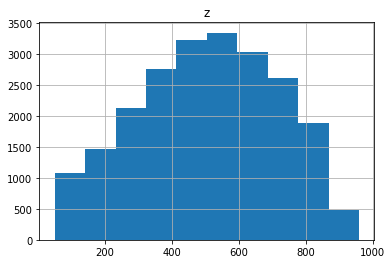

In [4]:
df_depths.hist()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


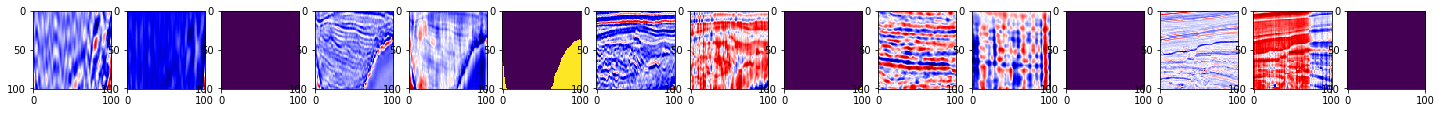

In [5]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(30,15))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('../input/train/images/' + img_name + '.png', grayscale=True)
    img_mask = load_img('../input/train/masks/' + img_name + '.png', grayscale=True)
    
    img = np.array(img)
    img_cumsum = (np.float32(img)-img.mean()).cumsum(axis=0)
    img_mask = np.array(img_mask)
    
    plt.subplot(1,3*(1+len(ids)),q*3-2)
    plt.imshow(img, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3-1)
    plt.imshow(img_cumsum, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3)
    plt.imshow(img_mask)
plt.show()

In [6]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [7]:
# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    
    # Depth
    X_feat[n] = df_depths.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [8]:
# Split train and valid
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [9]:
# Normalize X_feat
x_feat_mean = X_feat_train.mean(axis=0, keepdims=True)
x_feat_std = X_feat_train.std(axis=0, keepdims=True)
X_feat_train -= x_feat_mean
X_feat_train /= x_feat_std

X_feat_valid -= x_feat_mean
X_feat_valid /= x_feat_std

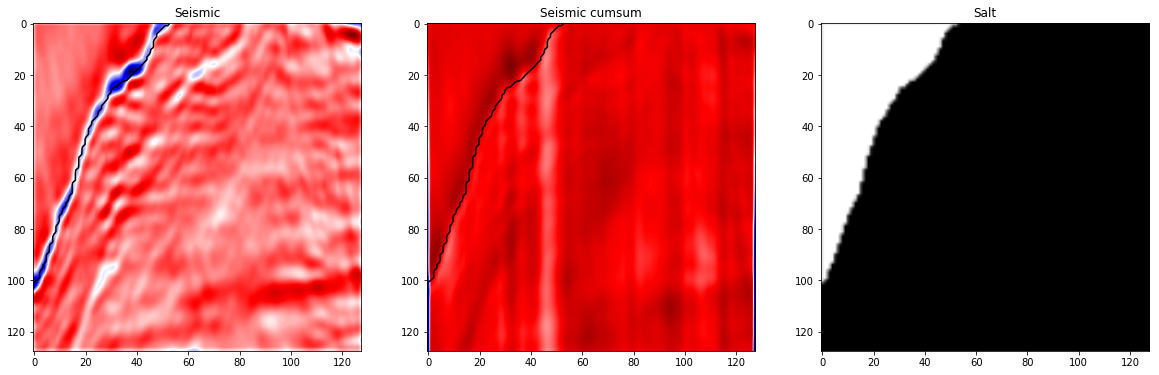

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))

has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(X_train[ix, ..., 1], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[1].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[1].set_title('Seismic cumsum')

ax[2].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[2].set_title('Salt');

# Train Model

In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [13]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - ETA: 14:25 - loss: 0.68 - ETA: 4:49 - loss: 0.6791 - ETA: 2:25 - loss: 0.655 - ETA: 1:36 - loss: 0.665 - ETA: 1:12 - loss: 0.645 - ETA: 58s - loss: 0.636 - ETA: 48s - loss: 0.62 - ETA: 41s - loss: 0.62 - ETA: 36s - loss: 0.62 - ETA: 32s - loss: 0.61 - ETA: 29s - loss: 0.61 - ETA: 26s - loss: 0.61 - ETA: 24s - loss: 0.61 - ETA: 22s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 19s - loss: 0.60 - ETA: 17s - loss: 0.61 - ETA: 16s - loss: 0.60 - ETA: 15s - loss: 0.60 - ETA: 14s - loss: 0.60 - ETA: 14s - loss: 0.59 - ETA: 13s - loss: 0.59 - ETA: 12s - loss: 0.58 - ETA: 11s - loss: 0.59 - ETA: 11s - loss: 0.59 - ETA: 10s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5855 - ETA: 9s - loss: 0.582 - ETA: 8s - loss: 0.579 - ETA: 8s - loss: 0.580 - ETA: 8s - loss: 0.577 - ETA: 7s - loss: 0.573 - ETA: 7s - loss: 0.573 - ETA: 7s - loss: 0.575 - ETA: 6s - loss: 0.574 - ETA: 6s - loss: 0.57

3400/3400 [==============================] - ETA: 5s - loss: 0.189 - ETA: 4s - loss: 0.265 - ETA: 4s - loss: 0.243 - ETA: 4s - loss: 0.256 - ETA: 4s - loss: 0.252 - ETA: 4s - loss: 0.251 - ETA: 4s - loss: 0.245 - ETA: 4s - loss: 0.234 - ETA: 4s - loss: 0.249 - ETA: 4s - loss: 0.248 - ETA: 4s - loss: 0.251 - ETA: 4s - loss: 0.246 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.246 - ETA: 4s - loss: 0.238 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.240 - ETA: 3s - loss: 0.240 - ETA: 3s - loss: 0.241 - ETA: 3s - loss: 0.244 - ETA: 3s - loss: 0.241 - ETA: 3s - loss: 0.239 - ETA: 3s - loss: 0.239 - ETA: 3s - loss: 0.236 - ETA: 3s - loss: 0.236 - ETA: 3s - loss: 0.234 - ETA: 3s - loss: 0.235 - ETA: 3s - loss: 0.234 - ETA: 3s - loss: 0.233 - ETA: 3s - loss: 0.232 - ETA: 3s - loss: 0.233 - ETA: 2s - loss: 0.230 - ETA: 2s - loss: 0.231 - ETA: 2s - loss: 0.229 - ETA: 2s - loss: 0.230 - ETA: 2s - loss: 0.228 - ETA: 2s - loss: 0.228 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.230 - ETA: 2s - loss: 0.2

3400/3400 [==============================] - ETA: 4s - loss: 0.159 - ETA: 5s - loss: 0.187 - ETA: 4s - loss: 0.176 - ETA: 4s - loss: 0.185 - ETA: 4s - loss: 0.194 - ETA: 4s - loss: 0.190 - ETA: 4s - loss: 0.189 - ETA: 4s - loss: 0.181 - ETA: 4s - loss: 0.179 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.165 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.156 - ETA: 3s - loss: 0.158 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.158 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.158 - ETA: 3s - loss: 0.157 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.158 - ETA: 2s - loss: 0.156 - ETA: 2s - loss: 0.156 - ETA: 2s - loss: 0.155 - ETA: 2s - loss: 0.154 - ETA: 2s - loss: 0.153 - ETA: 2s - loss: 0.151 - ETA: 2s - loss: 0.1

# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.

In [13]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.float32)
X_feat_test = np.zeros((len(test_ids), n_features), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    
    # Depth
    X_feat_test[n] = df_depths.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x = img_to_array(img)
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x[border:-border, border:-border].mean()
    x_csum = (np.float32(x)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Save images
    X_test[n, ..., 0] = x.squeeze() / 255
    X_test[n, ..., 1] = x_csum.squeeze()

print('Done!')

Getting and resizing test images ... 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [14]:
# Normalize X_test_feats
X_feat_test -= x_feat_mean
X_feat_test /= x_feat_std

In [15]:
# Load best model
model.load_weights('model-tgs-salt-1.h5')

In [16]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate({'img': X_valid, 'feat': X_feat_valid}, y_valid, verbose=1)

600/600 [==============================] - ETA: 22 - ETA: 3 - ETA:  - ETA:  - ETA:  - 2s 3ms/step


0.18530709892511368

In [17]:
# Predict on train, val and test
preds_train = model.predict({'img': X_train, 'feat': X_feat_train}, verbose=1)
preds_val = model.predict({'img': X_valid, 'feat': X_feat_valid}, verbose=1)
preds_test = model.predict({'img': X_test, 'feat': X_feat_test}, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - E

In [18]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [19]:
preds_test_upsampled[0].shape

(101, 101)

We'll look at it again, just to be sure.

In [20]:
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Seismic cumsum')

    ax[2].imshow(y[ix].squeeze())
    ax[2].set_title('Salt')

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Pred');

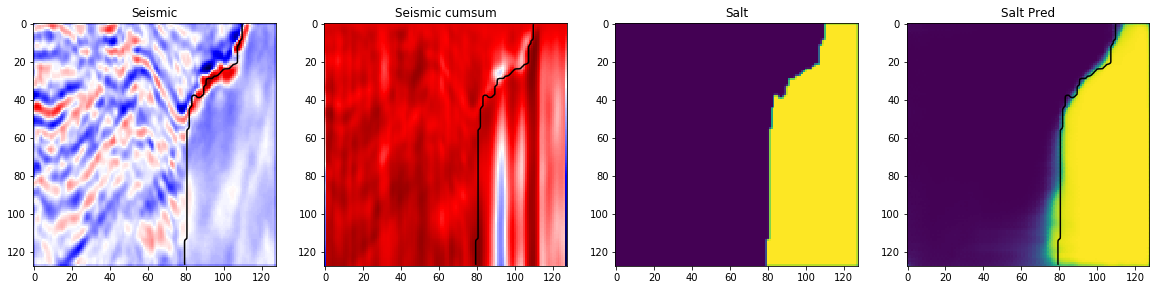

In [21]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)

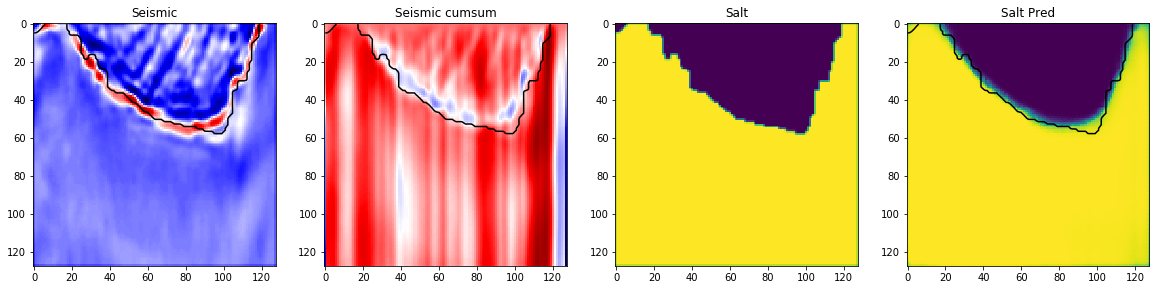

In [22]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val)

# Threshold optimization

In [23]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(y_valid, np.int32(preds_val > t)) for t in tqdm_notebook(thres)]

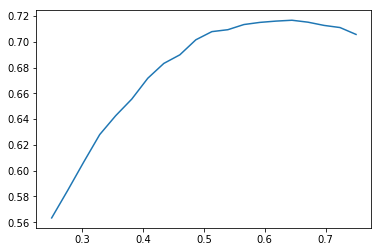

In [25]:
plt.plot(thres, thres_ioc);

In [26]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.6447368421052632, 0.7166666666666667)

# Prepare Submission
We need to prepare the submission. A nice CSV with predictions. All of this is one to one from Ketil and does not differ from any of the other segmentation tasks. Check them out to improve on this.

In [27]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {id_[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [29]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [31]:
pred_dict

{'0005bb9630': '',
 '000a68e46c': '',
 '000c8dfb2a': '',
 '000d0a5f6c': '',
 '001ef8fc87': '1 7169 7172 95 7273 77 7375 70 7478 61 7580 49 7684 30 7789 22 7894 16 8001 9 8106 5',
 '002124aa19': '2520 6 2618 9 2715 13 2812 17 2908 22 3004 27 3101 31 3198 35 3285 49 3357 78 3451 85 3548 89 3644 94 3740 6361 10102 100',
 '002af5d1e8': '8184 11 8284 15 8301 1 8303 2 8384 28 8485 35 8586 39 8687 46 8788 47 8889 46 8990 45 9091 44 9192 44 9293 44 9394 44 9495 44 9596 44 9697 44 9798 45 9899 45 10000 45 10102 42',
 '00323f1910': '67 32 162 39 263 39 364 39 465 40 566 40 667 40 768 40 870 39 972 38 1074 37 1175 37 1277 36 1379 35 1481 34 1581 35 1680 37 1781 3 1788 31 1882 2 1890 30 1983 1 1993 28 2094 27 2196 24 2277 1 2286 1 2297 23 2328 4 2384 6 2395 26 2431 6 2487 5 2494 28 2533 7 2596 28 2699 26 2804 20 3094 1 3192 6 3292 9 3396 6 3403 2 3505 1',
 '00329dc15c': '',
 '0035c56490': '',
 '0041cb8c49': '1 98 102 98 203 98 304 98 405 98 506 98 607 98 708 97 809 97 910 95 1011 88 1112 87 1213 8

In [32]:
sub

,rle_mask
id,
0005bb9630,
000a68e46c,
000c8dfb2a,
000d0a5f6c,
001ef8fc87,1 7169 7172 95 7273 77 7375 70 7478 61 7580 49...
002124aa19,2520 6 2618 9 2715 13 2812 17 2908 22 3004 27 ...
002af5d1e8,8184 11 8284 15 8301 1 8303 2 8384 28 8485 35 ...
00323f1910,67 32 162 39 263 39 364 39 465 40 566 40 667 4...
00329dc15c,
